# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [30]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional


## Data Load

In [2]:
datapath = ".\Data\dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [3]:
display(data)

,Disease,User_input
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
10329,Dermatitis,The discomfort in my skin has made it challeng...
10330,Dermatitis,"The raw, sensitive skin from scratching has ma..."
10331,Dermatitis,"I feel like my skin is tearing apart, causing ..."
10332,Dermatitis,Engaging in physical activities has become unb...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10334 entries, 0 to 10333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10334 non-null  object
 1   User_input  10334 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [5]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10334 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


<Axes: title={'center': 'Dataset balancing'}, xlabel='Disease'>

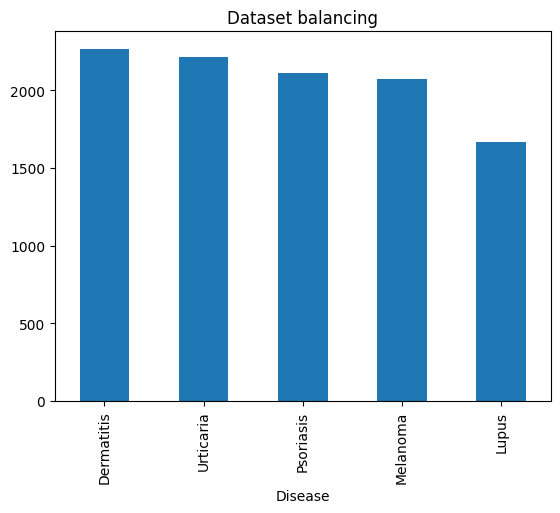

In [6]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

## Model Evaluation

In [22]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    
    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [5]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [6]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')


## Data Visualization

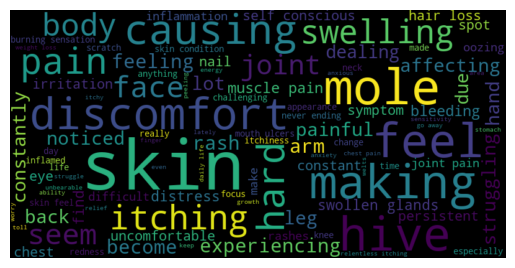

In [19]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

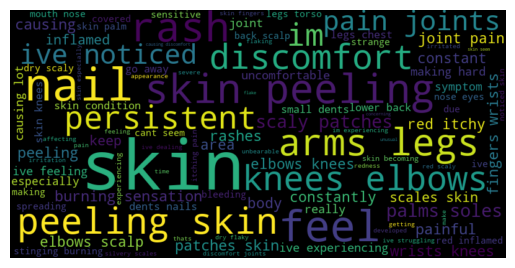

In [20]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

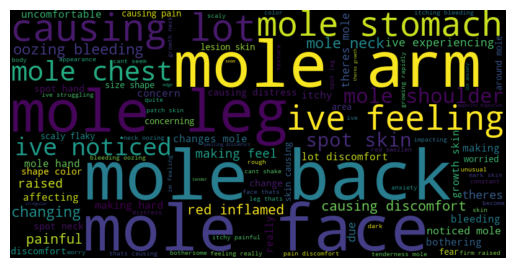

In [21]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

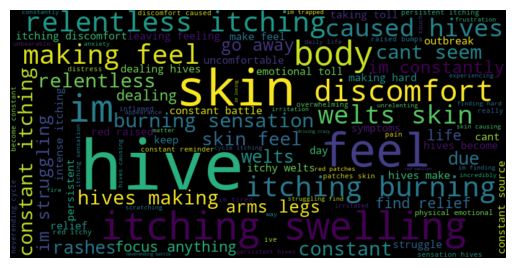

In [22]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

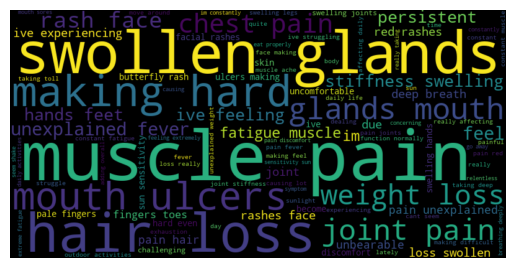

In [23]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

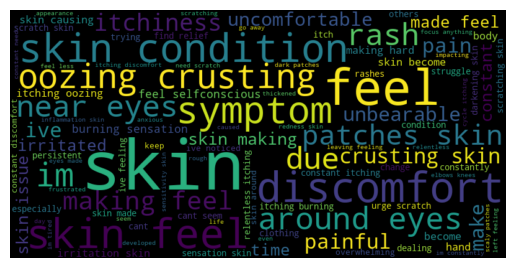

In [24]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [11]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [13]:
#nltk.download('wordnet')

In [7]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [8]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [9]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [29]:
display(data)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
0,Psoriasis,"[I, have, been, experiencing, a, skin, rash, o...","[experiencing, skin, rash, arms, legs, torso, ...","[experienc, skin, rash, arm, leg, torso, past,...","[experiencing, skin, rash, arm, leg, torso, pa..."
1,Psoriasis,"[My, skin, has, been, peeling,, especially, on...","[my, skin, peeling, especially, knees, elbows,...","[my, skin, peel, especi, knee, elbow, scalp, t...","[my, skin, peeling, especially, knee, elbow, s..."
2,Psoriasis,"[I, have, been, experiencing, joint, pain, in,...","[experiencing, joint, pain, fingers, wrists, k...","[experienc, joint, pain, finger, wrist, knee, ...","[experiencing, joint, pain, finger, wrist, kne..."
3,Psoriasis,"[There, is, a, silver, like, dusting, on, my, ...","[there, silver, like, dusting, skin, especiall...","[there, silver, like, dust, skin, especi, lowe...","[there, silver, like, dusting, skin, especiall..."
4,Psoriasis,"[My, nails, have, small, dents, or, pits, in, ...","[my, nails, small, dents, pits, them, often, f...","[my, nail, small, dent, pit, them, often, feel...","[my, nail, small, dent, pit, them, often, feel..."
...,...,...,...,...,...
10329,Dermatitis,"[The, discomfort, in, my, skin, has, made, it,...","[the, discomfort, skin, made, challenging, par...","[the, discomfort, skin, made, challeng, partak...","[the, discomfort, skin, made, challenging, par..."
10330,Dermatitis,"[The, raw,, sensitive, skin, from, scratching,...","[the, raw, sensitive, skin, scratching, made, ...","[the, raw, sensit, skin, scratch, made, unbear...","[the, raw, sensitive, skin, scratching, made, ..."
10331,Dermatitis,"[I, feel, like, my, skin, is, tearing, apart,,...","[feel, like, skin, tearing, apart, causing, ex...","[feel, like, skin, tear, apart, caus, excruci,...","[feel, like, skin, tearing, apart, causing, ex..."
10332,Dermatitis,"[Engaging, in, physical, activities, has, beco...","[engaging, physical, activities, become, unbea...","[engag, physic, activ, becom, unbear, due, sen...","[engaging, physical, activity, become, unbeara..."


## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [10]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [11]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(4,4))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [12]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))


In [110]:
#Smoothing to avoid 0 probabilities
#data_tfidf = data_tfidf + 1

# Normalize
#data_tfidf = data_tfidf.div(data_tfidf.sum(axis=1), axis=0)

#display(data_tfidf)

,abdomen,abdominal,abilities,ability,ablaze,able,abnormal,abnormalities,abnormality,abnormally,...,years,yellow,yellowish,yet,youth,youthful,zapped,zapping,zest,zoning
0,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
1,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
2,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
3,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
4,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10329,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
10330,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
10331,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336
10332,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,...,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336,0.000336


## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [14]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8267 rows and 5 columns.
Test dataset contains 2067 rows and 5 columns.


In [50]:
display(train)

,Disease,User_input,User_input_preprocessed,User_input_preprocessed_stem,User_input_preprocessed_lem
4880,Urticaria,"[I'm, struggling, to, find, moments, of, peace...","[im, struggling, find, moments, peace, amidst,...","[im, struggl, find, moment, peac, amidst, chao...","[im, struggling, find, moment, peace, amidst, ..."
6651,Lupus,"[My, sensitivity, to, sunlight, is, causing, m...","[my, sensitivity, sunlight, causing, lot, disc...","[my, sensit, sunlight, caus, lot, discomfort, ...","[my, sensitivity, sunlight, causing, lot, disc..."
6451,Urticaria,"[The, hives, have, disrupted, every, aspect, o...","[the, hives, disrupted, every, aspect, life, w...","[the, hive, disrupt, everi, aspect, life, work...","[the, hive, disrupted, every, aspect, life, wo..."
4157,Melanoma,"[I've, recently, noticed, this, growth, on, my...","[ive, recently, noticed, growth, leg, causing,...","[ive, recent, notic, growth, leg, caus, lot, t...","[ive, recently, noticed, growth, leg, causing,..."
828,Psoriasis,"[I, struggle, with, painful, swelling, in, my,...","[struggle, painful, swelling, joints, daily]","[struggl, pain, swell, joint, daili]","[struggle, painful, swelling, joint, daily]"
...,...,...,...,...,...
5734,Urticaria,"[The, hives, on, my, skin, have, caused, such,...","[the, hives, skin, caused, intense, itching, s...","[the, hive, skin, caus, intens, itch, swell, l...","[the, hive, skin, caused, intense, itching, sw..."
5191,Urticaria,"[The, itching, and, swelling, have, become, a,...","[the, itching, swelling, become, constant, sou...","[the, itch, swell, becom, constant, sourc, str...","[the, itching, swelling, become, constant, sou..."
5390,Urticaria,"[It, feels, like, I'm, living, in, a, body, th...","[it, feels, like, im, living, body, thats, hij...","[it, feel, like, im, live, bodi, that, hijack,...","[it, feel, like, im, living, body, thats, hija..."
860,Psoriasis,"[I'm, frustrated, by, the, visible, scales, th...","[im, frustrated, visible, scales, formed, body]","[im, frustrat, visibl, scale, form, bodi]","[im, frustrated, visible, scale, formed, body]"


#### Define X

##### BoW

In [19]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### Ngram

In [ ]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [ ]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

#### Define Y

In [15]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [25]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [16]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'], max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,  
            trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params
     

##### Grid Search

In [17]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_

##### Run Model

In [21]:
def model_lr(best_param, X_train, X_test, model_type):
    lr = LogisticRegression(solver=best_param['solver'], penalty=best_param['penalty'], C=best_param['C'], max_iter=best_param['max_iter'])
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    if score > best_Score_lr:
        best_Score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [28]:
name = "LR_withoutyproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

In [69]:
best_params = grid_search_lr(X_train_bow_noproc,y_train)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_noproc,y_train)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_noproc,y_train)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

##### With Preprocessing

In [ ]:
name = "LR_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_proc,y_train)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_proc,y_train)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_proc,y_train)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

##### With lamatization

In [ ]:
name = "LR_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

##### Witth stemming

In [ ]:
name = "LR_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

#### Naive Bayes

**Important Parameters:**
- Var Smoothing

##### Hyperopt ####

In [25]:
def hyperopt_nb(X_train):
    space = {
        'var_smoothing': hp.choice('var_smoothing', np.logspace(0, -9, num=100))
    }

    def objective(params):
        clf = GaussianNB(var_smoothing=params['var_smoothing'])
        score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,
            trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)

100%|██████████| 50/50 [01:26<00:00,  1.73s/trial, best loss: -0.755535170745945]
Best hyperparameters: {'var_smoothing': 0.0533669923120631}


##### Grid Search

In [166]:
def grid_search_bn(X_train):
    nb = GaussianNB()

    param_grid = {
        'var_smoothing': np.logspace(0,-9, num=100)
    }

    gs_nb = GridSearchCV(estimator=nb, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    gs_nb.fit(X_train.toarray(), y_train)

    print(f"Best parameters: {gs_nb.best_params_}")

Best parameters: {'var_smoothing': 0.1}


##### Function Naive Bayes #####


Training Data Results
Accuracy Score: 0.8375
Specificity Score: 0.8375
Precision Score: 0.8409
F1 Score: 0.8322

Testing Data Results
Accuracy Score: 0.7596
Specificity Score: 0.7596
Precision Score: 0.7577
F1 Score: 0.7517

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.87      0.63      0.73      1803
       Lupus       0.84      0.98      0.90      1355
    Melanoma       0.83      0.99      0.90      1677
   Psoriasis       0.86      0.77      0.82      1668
   Urticaria       0.80      0.86      0.83      1764

    accuracy                           0.84      8267
   macro avg       0.84      0.85      0.84      8267
weighted avg       0.84      0.84      0.83      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.73      0.53      0.62       463
       Lupus       0.78      0.93      0.85       314
    Melanoma       0.77      0.95      0.86       393
   Psoriasis 

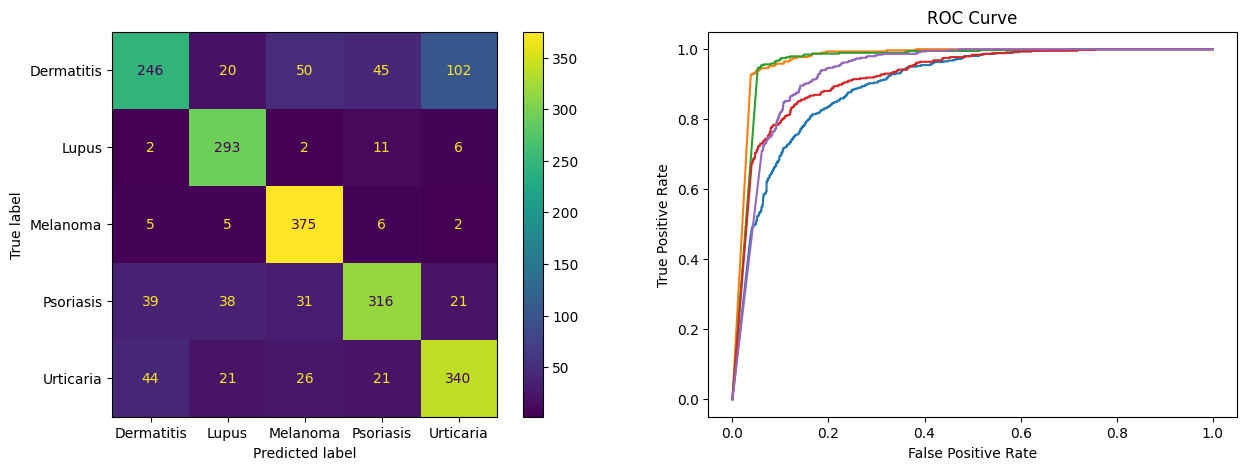

In [26]:
naive_bayes = GaussianNB(var_smoothing=0.0533669923120631)
model = naive_bayes.fit(X_train.toarray(), y_train)

evaluate(model, X_train.toarray(), X_test.toarray(), y_train, y_test)

#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

##### Hyperopt #####

In [19]:
def hyperopt_svm(X_train, y_train):
    space = {
        'C': hp.choice('C', [0.1, 1, 10, 100, 1000]),
        'gamma': hp.choice('gamma', [1, 0.1, 0.01, 0.001, 0.0001]),
        'kernel': hp.choice('kernel', ['rbf', 'linear'])
    }

    def objective(params):
        clf = SVC(C=1, gamma=params['gamma'], kernel=params['kernel'])
        score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
        return -score 

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,
            trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)

100%|██████████| 50/50 [2:54:32<00:00, 209.45s/trial, best loss: -0.8808512755014334]  
Best hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


##### Grid Search

In [2]:
def grid_search_svm(X_train, y_train):
    svm = SVC()

    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }

    gs_svm = GridSearchCV(estimator=svm, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    gs_svm.fit(X_train.toarray(), y_train)

    print(f"Best parameters: {gs_svm.best_params_}")


NameError: name 'SVC' is not defined

##### Function Support Vector Machine ####


Training Data Results
Accuracy Score: 0.8409
Specificity Score: 0.8409
Precision Score: 0.8825
F1 Score: 0.8473

Testing Data Results
Accuracy Score: 0.8031
Specificity Score: 0.8031
Precision Score: 0.8529
F1 Score: 0.8102

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.61      0.95      0.74      1803
       Lupus       0.97      0.85      0.90      1355
    Melanoma       1.00      0.93      0.96      1677
   Psoriasis       0.91      0.67      0.77      1668
   Urticaria       0.96      0.80      0.87      1764

    accuracy                           0.84      8267
   macro avg       0.89      0.84      0.85      8267
weighted avg       0.88      0.84      0.85      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.57      0.94      0.71       463
       Lupus       0.94      0.76      0.84       314
    Melanoma       0.99      0.92      0.95       393
   Psoriasis 

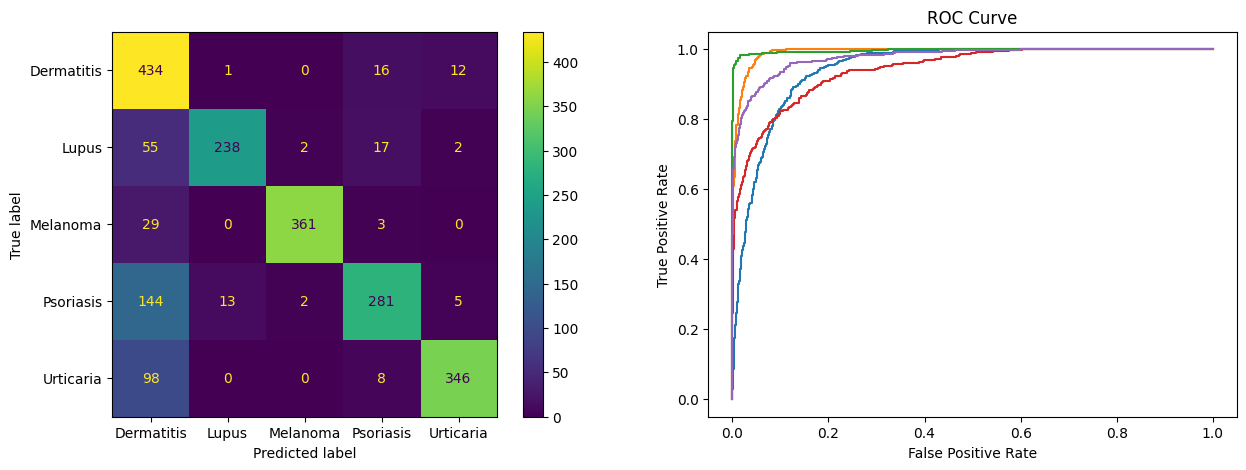

In [21]:
svm = SVC(C=0.1, gamma=1,kernel='rbf', probability=True)
model = svm.fit(X_train, y_train)

evaluate(model, X_train, X_test, y_train, y_test)

### Deep Learning

#### Recurrent Neural Network

In [29]:
# Create RNN model for text classification
vocab_size = 5000
embedding_dim = 32

rnn = Sequential(name="Basic_RNN")
rnn.add(Embedding(vocab_size, embedding_dim))
rnn.add(SimpleRNN(128, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(64, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(32, activation='relu'))
rnn.add(Dense(4, activation='softmax'))

rnn.build(input_shape=(None, X_train.shape[1]))

print(rnn.summary())

rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#history = rnn.fit(X_train.toarray(), y_train, epochs=10, validation_data=(X_test.toarray(), y_test))

Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (None, 2703, 128)      │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (None, 2703, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,196 (766.39 KB)

 Trainable params: 196,196 (766.39 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Conv 1D

In [31]:
# Create Conv1D model for text classification
conv1d = Sequential(name="Conv1D")
conv1d.add(Embedding(vocab_size, embedding_dim))
conv1d.add(Conv1D(128, 5, activation='relu'))
conv1d.add(GlobalMaxPooling1D())
conv1d.add(Dense(64, activation='relu'))
conv1d.add(Dense(4, activation='softmax'))

conv1d.build(input_shape=(None, X_train.shape[1]))

print(conv1d.summary())

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2699, 128)      │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,124 (738.77 KB)

 Trainable params: 189,124 (738.77 KB)

 Non-trainable params: 0 (0.00 B)

None


#### LSTM

In [36]:
# Create LSTM model for text classification
lstm = Sequential(name="LSTM")
lstm.add(Embedding(vocab_size, embedding_dim))
lstm.add(LSTM(32))
lstm.add(Dropout(0.4))
lstm.add(Dense(4, activation='softmax'))

lstm.build(input_shape=(None, X_train.shape[1]))

print(lstm.summary())

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,452 (658.02 KB)

 Trainable params: 168,452 (658.02 KB)

 Non-trainable params: 0 (0.00 B)

None


#### BILSTM

In [41]:
# Create LSTM model for text classification
blstm = Sequential(name="Bi_LSTM")
blstm.add(Embedding(vocab_size, embedding_dim))
blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
blstm.add(Dropout(0.4))
blstm.add(Bidirectional(LSTM(32)))
blstm.add(Dropout(0.2))
blstm.add(Dense(64, activation='relu'))
blstm.add(Dropout(0.1))
blstm.add(Dense(4, activation='softmax'))

blstm.build(input_shape=(None, X_train.shape[1]))

print(blstm.summary())


c:\Users\Maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 2703, 128)      │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2703, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,300 (997.27 KB)

 Trainable params: 255,300 (997.27 KB)

 Non-trainable params: 0 (0.00 B)

None
